# Neural Network (Multi-Layer Perceptron) on CIFAR-10 using PyTorch

1. **Input Layer**: Raw pixel values (3072 features for CIFAR-10)
2. **Hidden Layers**: Dense layers with non-linear activations (e.g., ReLU)
3. **Regularization**: Optional Dropout / Weight Decay
4. **Output Layer**: Class scores (10 outputs for CIFAR-10)
5. **Softmax Function**: Converts scores to probabilities

### Mathematical Foundation:
- **Forward Pass (MLP)**: `h1 = ReLU(X @ W1 + b1); h2 = ReLU(h1 @ W2 + b2); scores = h2 @ W3 + b3`
- **Softmax**: `P(y=k|x) = exp(score_k) / Σ exp(score_j)`
- **Cross-Entropy Loss**: `L = -log(P(y=correct_class|x))`
- **Regularization**: `L_total = L_data + λ * L_reg`

## Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tarfile
import urllib.request
import os
import time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, matthews_corrcoef, confusion_matrix, 
                           roc_auc_score, roc_curve, classification_report,
                           log_loss)
from sklearn.linear_model import LogisticRegression

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

Using device: cpu


## CIFAR-10 Dataset

### About CIFAR-10:
- **Created by**: Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton at the University of Toronto
- **Source**: https://www.cs.toronto.edu/~kriz/cifar.html
- **Images**: 32×32 color images 
- **Classes**: 10 
- **Size**: 60,000 images total (50,000 training + 10,000 testing)

### Classes:
1. **Airplane** - Various aircraft types
2. **Automobile** - Cars, trucks, and other vehicles  
3. **Bird** - Different bird species
4. **Cat** - Domestic cats in various poses
5. **Deer** - Wild deer and similar animals
6. **Dog** - Various dog breeds
7. **Frog** - Frogs and toads
8. **Horse** - Horses in different settings
9. **Ship** - Naval vessels and boats
10. **Truck** - Large vehicles and trucks


## Download and Load Dataset

In [2]:
def download_cifar10():
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar-10-python.tar.gz"
    extracted_dir = "cifar-10-batches-py"
    
    if not os.path.exists("data"):
        os.makedirs("data")
    
    filepath = os.path.join("data", filename)
    extracted_path = os.path.join("data", extracted_dir)
    
    if os.path.exists(extracted_path):
        print("CIFAR-10 dataset already exists!")
        return extracted_path
    
    if not os.path.exists(filepath):
        print("Downloading CIFAR-10 dataset...")
        print(f"   Source: {url}")
        urllib.request.urlretrieve(url, filepath)
        print("Download completed!")

    print("Extracting dataset...")
    with tarfile.open(filepath, 'r:gz') as tar:
        tar.extractall("data")
    print("Extraction completed!")
    
    return extracted_path

def load_batch(file_path):
    with open(file_path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    
    data = batch[b'data']
    labels = batch[b'labels']
    data = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    
    return data, labels

def load_cifar10(data_dir):
    print("Loading CIFAR-10 dataset...")
    
    train_data = []
    train_labels = []
    
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        data, labels = load_batch(batch_file)
        train_data.append(data)
        train_labels.extend(labels)
    
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.array(train_labels)
    
    test_file = os.path.join(data_dir, 'test_batch')
    test_data, test_labels = load_batch(test_file)
    test_labels = np.array(test_labels)
    
    meta_file = os.path.join(data_dir, 'batches.meta')
    with open(meta_file, 'rb') as f:
        meta = pickle.load(f, encoding='bytes')
    class_names = [name.decode('utf-8') for name in meta[b'label_names']]
    
    print("Dataset loaded successfully!")
    
    return (train_data, train_labels), (test_data, test_labels), class_names

In [3]:
data_dir = download_cifar10()
(X_train_full, y_train_full), (X_test, y_test), class_names = load_cifar10(data_dir)

CIFAR-10 dataset already exists!
Loading CIFAR-10 dataset...
Dataset loaded successfully!
Dataset loaded successfully!


## Dataset Information and Statistics

In [4]:
print(f"Training samples: {X_train_full.shape[0]:,}")
print(f"Test samples: {X_test.shape[0]:,}")
print(f"Image shape: {X_train_full.shape[1:]} (Height × Width × Channels)")
print(f"Total features per image: {np.prod(X_train_full.shape[1:]):,}")
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")

unique, counts = np.unique(y_train_full, return_counts=True)
print(f"\nClass Distribution (Training Set):")
for i, (class_idx, count) in enumerate(zip(unique, counts)):
    print(f"   {class_idx}. {class_names[class_idx]:12s}: {count:,} samples ({count/len(y_train_full)*100:.1f}%)")

is_balanced = len(set(counts)) == 1
print(f"\nDataset is {'balanced' if is_balanced else 'imbalanced'}")

# Data types and ranges
print(f"\nData characteristics:")
print(f"   Data type: {X_train_full.dtype}")
print(f"   Pixel value range: [{X_train_full.min()}, {X_train_full.max()}]")
print(f"   Label type: {y_train_full.dtype}")
print(f"   Label range: [{y_train_full.min()}, {y_train_full.max()}]")

Training samples: 50,000
Test samples: 10,000
Image shape: (32, 32, 3) (Height × Width × Channels)
Total features per image: 3,072
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Class Distribution (Training Set):
   0. airplane    : 5,000 samples (10.0%)
   1. automobile  : 5,000 samples (10.0%)
   2. bird        : 5,000 samples (10.0%)
   3. cat         : 5,000 samples (10.0%)
   4. deer        : 5,000 samples (10.0%)
   5. dog         : 5,000 samples (10.0%)
   6. frog        : 5,000 samples (10.0%)
   7. horse       : 5,000 samples (10.0%)
   8. ship        : 5,000 samples (10.0%)
   9. truck       : 5,000 samples (10.0%)

Dataset is balanced

Data characteristics:
   Data type: uint8
   Pixel value range: [0, 255]
   Label type: int64
   Label range: [0, 9]


## Visualize Sample Images

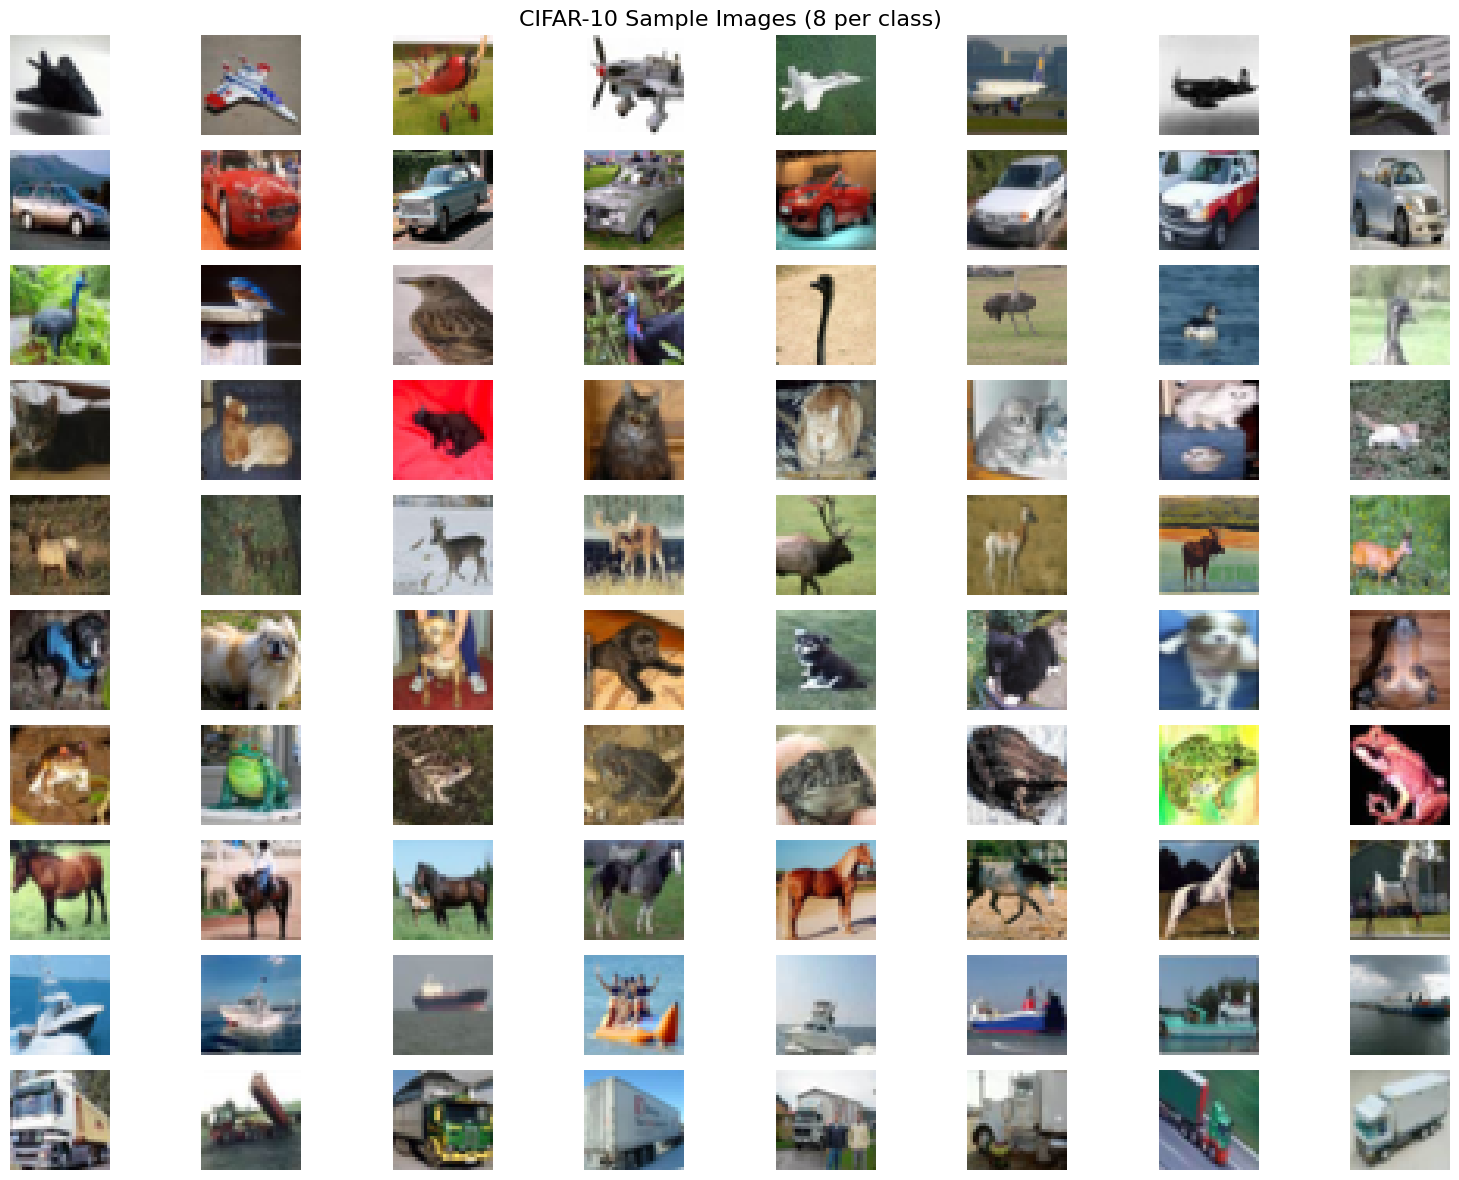

In [5]:
plt.figure(figsize=(16, 12))

for class_idx in range(10):
    class_indices = np.where(y_train_full == class_idx)[0]
    
    for i in range(8):
        plt.subplot(10, 8, class_idx * 8 + i + 1)
        image = X_train_full[class_indices[i]]
        
        plt.imshow(image)
        if i == 0: 
            plt.ylabel(f'{class_idx}: {class_names[class_idx]}', rotation=0, 
                      ha='right', va='center', fontsize=10)
        plt.axis('off')

plt.suptitle('CIFAR-10 Sample Images (8 per class)', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()


## Pixel Intensity Analysis

Pixel Intensity Statistics:
Red Channel   - Mean: 125.3, Std: 63.0
Red Channel   - Mean: 125.3, Std: 63.0
Green Channel - Mean: 123.0, Std: 62.1
Green Channel - Mean: 123.0, Std: 62.1
Blue Channel  - Mean: 113.9, Std: 66.7
Blue Channel  - Mean: 113.9, Std: 66.7
Overall       - Mean: 120.7, Std: 64.2
Overall       - Mean: 120.7, Std: 64.2


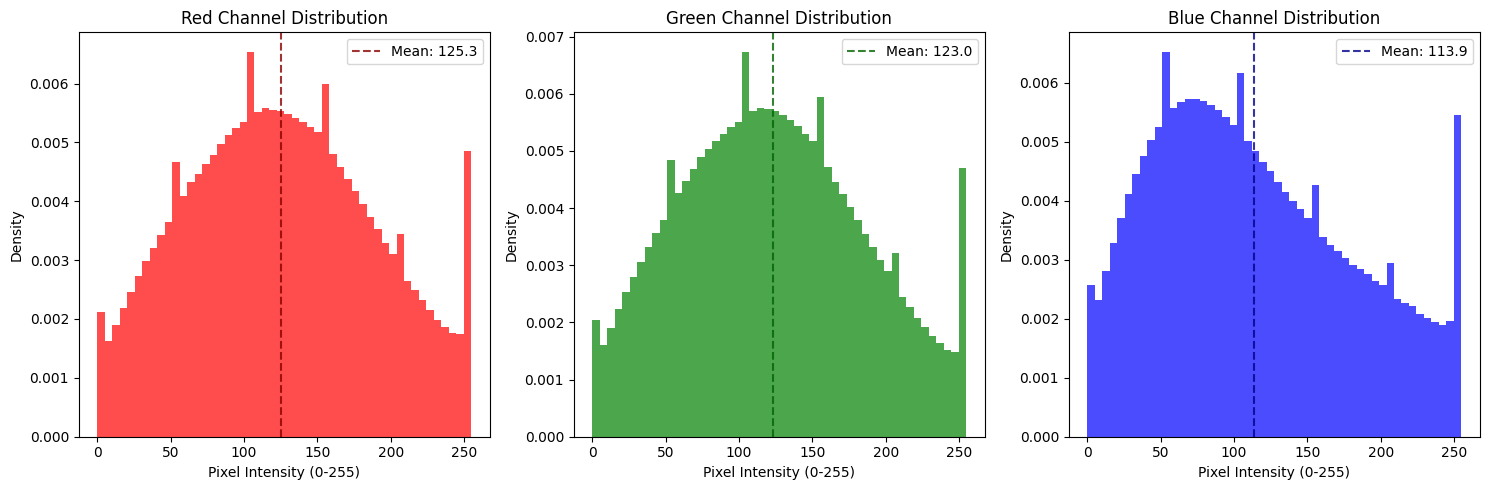

Computing average images per class...


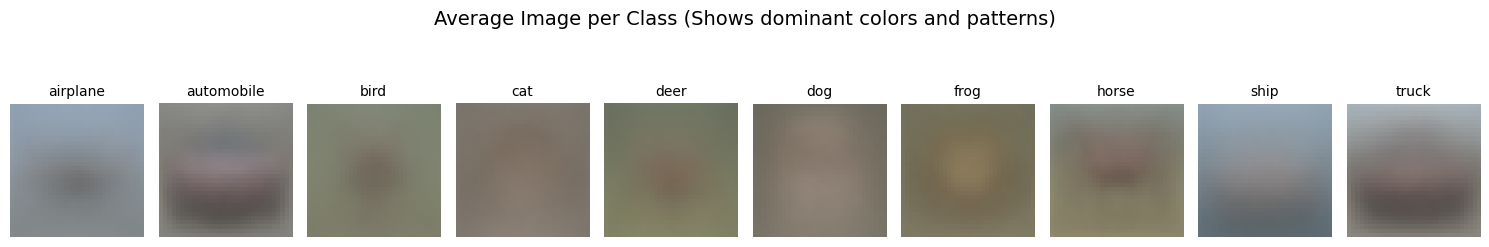

In [6]:
r_channel = X_train_full[:,:,:,0]
g_channel = X_train_full[:,:,:,1] 
b_channel = X_train_full[:,:,:,2]

print("Pixel Intensity Statistics:")
print(f"Red Channel   - Mean: {r_channel.mean():.1f}, Std: {r_channel.std():.1f}")
print(f"Green Channel - Mean: {g_channel.mean():.1f}, Std: {g_channel.std():.1f}")
print(f"Blue Channel  - Mean: {b_channel.mean():.1f}, Std: {b_channel.std():.1f}")
print(f"Overall       - Mean: {X_train_full.mean():.1f}, Std: {X_train_full.std():.1f}")


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(r_channel.flatten(), bins=50, alpha=0.7, color='red', density=True)
plt.title('Red Channel Distribution')
plt.xlabel('Pixel Intensity (0-255)')
plt.ylabel('Density')
plt.axvline(r_channel.mean(), color='darkred', linestyle='--', alpha=0.8, label=f'Mean: {r_channel.mean():.1f}')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(g_channel.flatten(), bins=50, alpha=0.7, color='green', density=True)
plt.title('Green Channel Distribution')
plt.xlabel('Pixel Intensity (0-255)')
plt.ylabel('Density')
plt.axvline(g_channel.mean(), color='darkgreen', linestyle='--', alpha=0.8, label=f'Mean: {g_channel.mean():.1f}')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(b_channel.flatten(), bins=50, alpha=0.7, color='blue', density=True)
plt.title('Blue Channel Distribution')
plt.xlabel('Pixel Intensity (0-255)')
plt.ylabel('Density')
plt.axvline(b_channel.mean(), color='darkblue', linestyle='--', alpha=0.8, label=f'Mean: {b_channel.mean():.1f}')
plt.legend()

plt.tight_layout()
plt.show()


print("Computing average images per class...")
avg_images = np.zeros((10, 32, 32, 3))
for class_idx in range(10):
    class_mask = y_train_full == class_idx
    avg_images[class_idx] = X_train_full[class_mask].mean(axis=0)


plt.figure(figsize=(15, 3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(avg_images[i].astype(np.uint8))
    plt.title(f'{class_names[i]}', fontsize=10)
    plt.axis('off')

plt.suptitle('Average Image per Class (Shows dominant colors and patterns)', fontsize=14)
plt.tight_layout()
plt.show()

## Data Preprocessing

### Preprocessing Pipeline:
1. **Flatten Images**: Convert 32×32×3 to 3072 features
2. **Normalize**: Scale pixel values from [0, 255] to [0, 1]
3. **Standardize**: Zero mean, unit variance (optional but recommended)
4. **Train/Validation Split**: 80%-20% split

In [7]:
X_train_flat = X_train_full.reshape(X_train_full.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print("Shape Transformation:")
print(f"   Original train shape: {X_train_full.shape}")
print(f"   Flattened train shape: {X_train_flat.shape}")
print(f"   Original test shape: {X_test.shape}")
print(f"   Flattened test shape: {X_test_flat.shape}")


X_train, X_val, y_train, y_val = train_test_split(
    X_train_flat, y_train_full, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train_full
)

print(f"Dataset Splits:")
print(f"   Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X_train_flat)*100:.1f}%)")
print(f"   Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X_train_flat)*100:.1f}%)")
print(f"   Test set: {X_test_flat.shape[0]:,} samples")


print(f"Normalization:")
print(f"   Original range: [{X_train.min()}, {X_train.max()}]")

X_train_norm = X_train.astype(np.float32) / 255.0
X_val_norm = X_val.astype(np.float32) / 255.0  
X_test_norm = X_test_flat.astype(np.float32) / 255.0

print(f"   Normalized range: [{X_train_norm.min():.3f}, {X_train_norm.max():.3f}]")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_norm)
X_val_scaled = scaler.transform(X_val_norm)
X_test_scaled = scaler.transform(X_test_norm)

print(f"Standardization:")
print(f"   Final range: [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}]")
print(f"   Mean: {X_train_scaled.mean():.6f}")
print(f"   Std: {X_train_scaled.std():.6f}")

print(f"Class Distribution Verification:")
train_unique, train_counts = np.unique(y_train, return_counts=True)
val_unique, val_counts = np.unique(y_val, return_counts=True)

print("Training set balance:")
for i, count in enumerate(train_counts):
    print(f"   Class {i}: {count:,} samples ({count/len(y_train)*100:.1f}%)")
    
print("Validation set balance:")
for i, count in enumerate(val_counts):
    print(f"   Class {i}: {count:,} samples ({count/len(y_val)*100:.1f}%)")

Shape Transformation:
   Original train shape: (50000, 32, 32, 3)
   Flattened train shape: (50000, 3072)
   Original test shape: (10000, 32, 32, 3)
   Flattened test shape: (10000, 3072)
Dataset Splits:
   Training set: 40,000 samples (80.0%)
   Validation set: 10,000 samples (20.0%)
   Test set: 10,000 samples
Normalization:
   Original range: [0, 255]
   Normalized range: [0.000, 1.000]
   Normalized range: [0.000, 1.000]
Standardization:
   Final range: [-2.204, 2.617]
   Mean: 0.000000
Standardization:
   Final range: [-2.204, 2.617]
   Mean: 0.000000
   Std: 1.000000
Class Distribution Verification:
Training set balance:
   Class 0: 4,000 samples (10.0%)
   Class 1: 4,000 samples (10.0%)
   Class 2: 4,000 samples (10.0%)
   Class 3: 4,000 samples (10.0%)
   Class 4: 4,000 samples (10.0%)
   Class 5: 4,000 samples (10.0%)
   Class 6: 4,000 samples (10.0%)
   Class 7: 4,000 samples (10.0%)
   Class 8: 4,000 samples (10.0%)
   Class 9: 4,000 samples (10.0%)
Validation set balance:
 

## Multi-Layer Neural Network (MLP) Implementation

### Architecture Overview:
```
Input (3072) → Dense(1024) → ReLU → Dense(512) → ReLU → Dropout(0.5) → Dense(10) → Softmax
```

### Mathematical Components:
- **Layered Transformations**: `h1 = ReLU(X @ W1 + b1)`, `h2 = ReLU(h1 @ W2 + b2)`, `z = h2 @ W3 + b3`
- **Softmax Function**: `softmax(z_i) = exp(z_i) / Σ exp(z_j)`
- **Cross-Entropy Loss**: `L = -Σ y_true * log(y_pred)`
- **Regularization**: `L_reg = λ * (||W1||² + ||W2||² + ||W3||²)`


In [ ]:
class MultiLayerNetwork(nn.Module):
    """
    Architecture: Input → Dense(1024) → ReLU → Dense(512) → ReLU → Dropout → Dense(10)
    """

    def __init__(self, input_size, num_classes, hidden_sizes=(1024, 512), dropout=0.2, use_bias=True):
        super(MultiLayerNetwork, self).__init__()

        h1, h2 = hidden_sizes
        self.input_size = input_size
        self.num_classes = num_classes

        self.fc1 = nn.Linear(input_size, h1, bias=use_bias)
        self.fc2 = nn.Linear(h1, h2, bias=use_bias)
        self.fc3 = nn.Linear(h2, num_classes, bias=use_bias)
        self.dropout = nn.Dropout(p=dropout)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        if x.dim() > 2:
            x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        logits = self.fc3(x)
        return logits

    def predict_proba(self, x):
        with torch.no_grad():
            logits = self.forward(x)
            probabilities = F.softmax(logits, dim=1)
        return probabilities

    def predict(self, x):
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

In [9]:
input_size = 3072  # 32 * 32 * 3
num_classes = 10  # CIFAR-10 classes

model = MultiLayerNetwork(input_size, num_classes, hidden_sizes=(1024, 512), dropout=0.5).to(device)

print("Model Architecture:")
print(model)
print(f"Model Parameters:")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   fc1 weight shape: {tuple(model.fc1.weight.shape)}, bias shape: {tuple(model.fc1.bias.shape)}")
print(f"   fc2 weight shape: {tuple(model.fc2.weight.shape)}, bias shape: {tuple(model.fc2.bias.shape)}")
print(f"   fc3 weight shape: {tuple(model.fc3.weight.shape)}, bias shape: {tuple(model.fc3.bias.shape)}")

print(f"Model Complexity Analysis:")
print(f"   Parameters: {total_params:,}")
print(f"   Training samples: {len(X_train):,}")
print(f"   Parameter-to-sample ratio: {total_params/len(X_train):.3f}")

Model Architecture:
MultiLayerNetwork(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Model Parameters:
   Total parameters: 3,676,682
   Trainable parameters: 3,676,682
   fc1 weight shape: (1024, 3072), bias shape: (1024,)
   fc2 weight shape: (512, 1024), bias shape: (512,)
   fc3 weight shape: (10, 512), bias shape: (10,)
Model Complexity Analysis:
   Parameters: 3,676,682
   Training samples: 40,000
   Parameter-to-sample ratio: 91.917


## Convert Data to PyTorch Tensors

In [10]:
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

y_train_tensor = torch.LongTensor(y_train).to(device)
y_val_tensor = torch.LongTensor(y_val).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

print("Data converted to PyTorch tensors:")
print(f"   X_train shape: {X_train_tensor.shape}, dtype: {X_train_tensor.dtype}")
print(f"   y_train shape: {y_train_tensor.shape}, dtype: {y_train_tensor.dtype}")
print(f"   Device: {X_train_tensor.device}")


batch_size = 256

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Data Loaders created:")
print(f"   Batch size: {batch_size}")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

train_memory = X_train_tensor.element_size() * X_train_tensor.nelement()
print(f"   Training data memory: {train_memory / (1024**2):.1f} MB on {device}")

Data converted to PyTorch tensors:
   X_train shape: torch.Size([40000, 3072]), dtype: torch.float32
   y_train shape: torch.Size([40000]), dtype: torch.int64
   Device: cpu
Data Loaders created:
   Batch size: 256
   Training batches: 157
   Validation batches: 40
   Test batches: 40
   Training data memory: 468.8 MB on cpu


## Training Configuration

In [11]:
config = {
    'learning_rate': 0.001,      # Adam default, good starting point
    'weight_decay': 1e-4,        # L2 regularization strength
    'num_epochs': 50,            # Number of training epochs
    'patience': 10,              # Early stopping patience
    'min_delta': 1e-6            # Minimum improvement for early stopping
}

print("Training Configuration:")
for key, value in config.items():
    print(f"   {key}: {value}")


criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), 
                       lr=config['learning_rate'], 
                       weight_decay=config['weight_decay'])

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                               mode='min', 
                                               factor=0.5, 
                                               patience=5)

print(f"Optimizer: {optimizer}")
print(f"Learning Rate Scheduler: {scheduler}")
print(f"Loss Function: {criterion}")


history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'learning_rates': []
}

Training Configuration:
   learning_rate: 0.001
   weight_decay: 0.0001
   num_epochs: 50
   patience: 10
   min_delta: 1e-06
Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Learning Rate Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x000002329E6A4390>
Loss Function: CrossEntropyLoss()
Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Learning Rate Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x000002329E6A4390>
Loss Function: CrossEntropyLoss()


## Training Functions

In [12]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = criterion(outputs, target)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += target.size(0)
        correct_predictions += (predicted == target).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_predictions / total_samples
    
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, target)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += target.size(0)
            correct_predictions += (predicted == target).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = correct_predictions / total_samples
    
    return epoch_loss, epoch_acc

def early_stopping_check(val_losses, patience, min_delta):
    if len(val_losses) <= patience:
        return False
    
    recent_losses = val_losses[-patience:]
    best_recent = min(recent_losses)
    current_loss = val_losses[-1]
    
    if current_loss > (best_recent - min_delta):
        return True
    
    return False

## Model Training with Progress Tracking

In [13]:
best_val_acc = 0.0
best_epoch = 0
training_start_time = time.time()


for epoch in range(config['num_epochs']):
    epoch_start_time = time.time()

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    scheduler.step(val_loss)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rates'].append(optimizer.param_groups[0]['lr'])
    
    epoch_time = time.time() - epoch_start_time
    
    print(f"Epoch {epoch+1:2d}/{config['num_epochs']:2d} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f} | "
          f"Time: {epoch_time:.2f}s")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss
        }, 'best_model.pth')
        print(f"         → New best validation accuracy: {val_acc:.4f}")
    
    if early_stopping_check(history['val_loss'], config['patience'], config['min_delta']):
        print(f"Early stopping triggered after epoch {epoch+1}")
        print(f"No improvement for {config['patience']} consecutive epochs")
        break

training_time = time.time() - training_start_time

print("Training Completed!")
print(f"Total training time: {training_time:.2f} seconds")
print(f"Best validation accuracy: {best_val_acc:.4f} (epoch {best_epoch})")
print(f"Final learning rate: {optimizer.param_groups[0]['lr']:.6f}")

Epoch  1/50 | Train Loss: 1.9582 | Train Acc: 0.3258 | Val Loss: 1.6526 | Val Acc: 0.4164 | LR: 0.001000 | Time: 9.21s
         → New best validation accuracy: 0.4164
Epoch  2/50 | Train Loss: 1.7036 | Train Acc: 0.3941 | Val Loss: 1.5887 | Val Acc: 0.4410 | LR: 0.001000 | Time: 8.99s
         → New best validation accuracy: 0.4410
Epoch  2/50 | Train Loss: 1.7036 | Train Acc: 0.3941 | Val Loss: 1.5887 | Val Acc: 0.4410 | LR: 0.001000 | Time: 8.99s
         → New best validation accuracy: 0.4410
Epoch  3/50 | Train Loss: 1.6260 | Train Acc: 0.4234 | Val Loss: 1.5135 | Val Acc: 0.4666 | LR: 0.001000 | Time: 8.41s
         → New best validation accuracy: 0.4666
Epoch  3/50 | Train Loss: 1.6260 | Train Acc: 0.4234 | Val Loss: 1.5135 | Val Acc: 0.4666 | LR: 0.001000 | Time: 8.41s
         → New best validation accuracy: 0.4666
Epoch  4/50 | Train Loss: 1.5570 | Train Acc: 0.4463 | Val Loss: 1.4889 | Val Acc: 0.4732 | LR: 0.001000 | Time: 8.28s
         → New best validation accuracy: 0.473

## Training Progress Visualization

Training Summary:
   Final training accuracy: 53.78%
   Final validation accuracy: 50.45%
   Best validation accuracy: 51.42%
   Training-validation gap: 3.33%
   Final training loss: 1.2849
   Final validation loss: 1.4124


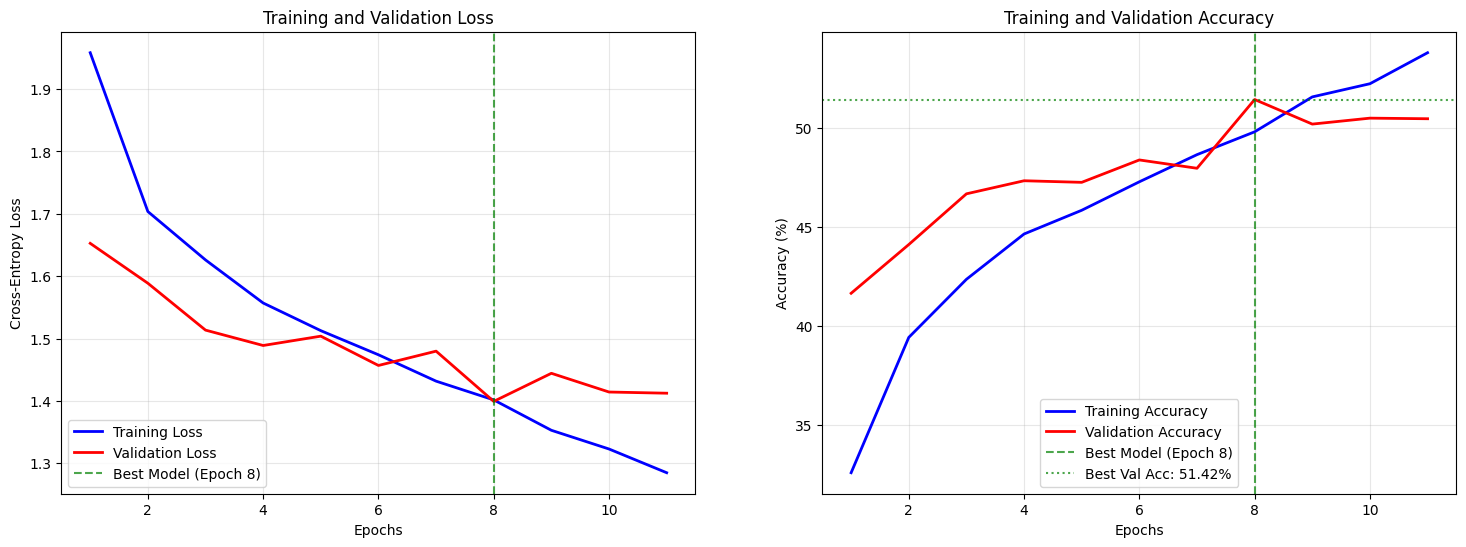

In [14]:
epochs_range = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs_range, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best Model (Epoch {best_epoch})')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, [acc*100 for acc in history['train_acc']], 'b-', label='Training Accuracy', linewidth=2)
plt.plot(epochs_range, [acc*100 for acc in history['val_acc']], 'r-', label='Validation Accuracy', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best Model (Epoch {best_epoch})')
plt.axhline(y=best_val_acc*100, color='green', linestyle=':', alpha=0.7, label=f'Best Val Acc: {best_val_acc*100:.2f}%')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)


print("Training Summary:")
print(f"   Final training accuracy: {history['train_acc'][-1]*100:.2f}%")
print(f"   Final validation accuracy: {history['val_acc'][-1]*100:.2f}%")
print(f"   Best validation accuracy: {best_val_acc*100:.2f}%")
print(f"   Training-validation gap: {(history['train_acc'][-1] - history['val_acc'][-1])*100:.2f}%")


final_train_loss = history['train_loss'][-1]
final_val_loss = history['val_loss'][-1]
print(f"   Final training loss: {final_train_loss:.4f}")
print(f"   Final validation loss: {final_val_loss:.4f}")

## Load Best Model and Evaluate

In [ ]:
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Best validation accuracy: {checkpoint['val_acc']:.4f}")

def evaluate_model(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []
    all_probabilities = []
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            
            outputs = model(data)
            probabilities = F.softmax(outputs, dim=1)
            predictions = torch.argmax(outputs, dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_targets), np.array(all_probabilities)

print("Evaluating model on all datasets...")


val_pred, val_true, val_prob = evaluate_model(model, val_loader, device)
val_accuracy = accuracy_score(val_true, val_pred)


test_pred, test_true, test_prob = evaluate_model(model, test_loader, device)
test_accuracy = accuracy_score(test_true, test_pred)

print("\nFinal Evaluation Results:")
print("="*50)
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Generalization Gap: {abs(val_accuracy - test_accuracy):.4f}")


print(f"\nPerformance Context for CIFAR-10:")
print(f"   Random guessing: ~10% accuracy")
print(f"   Simple heuristics: ~20-30% accuracy") 
print(f"   MLP (ours): {test_accuracy*100:.1f}% accuracy")



Loaded best model from epoch 8
Best validation accuracy: 0.5142
Evaluating model on all datasets...

Final Evaluation Results:
Validation Accuracy: 0.5142 (51.42%)
Test Accuracy: 0.5063 (50.63%)
Generalization Gap: 0.0079

Performance Context for CIFAR-10:
   Random guessing: ~10% accuracy
   Simple heuristics: ~20-30% accuracy
   MLP (ours): 50.6% accuracy

Final Evaluation Results:
Validation Accuracy: 0.5142 (51.42%)
Test Accuracy: 0.5063 (50.63%)
Generalization Gap: 0.0079

Performance Context for CIFAR-10:
   Random guessing: ~10% accuracy
   Simple heuristics: ~20-30% accuracy
   MLP (ours): 50.6% accuracy


## Detailed Performance Analysis

In [16]:
def detailed_classification_report(y_true, y_pred, class_names, dataset_name):    
    print(f"{'='*60}")
    print(f"{dataset_name} Set - Detailed Performance Analysis")
    print(f"{'='*60}")
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    mcc = matthews_corrcoef(y_true, y_pred)
    
    print(f"Overall Metrics:")
    print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Precision: {precision:.4f} (macro-averaged)")
    print(f"   Recall:    {recall:.4f} (macro-averaged)")
    print(f"   F1-Score:  {f1:.4f} (macro-averaged)")
    print(f"   MCC:       {mcc:.4f} (Matthews Correlation)")
    

    cm = confusion_matrix(y_true, y_pred)
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    
    print(f"Per-Class Performance:")
    print(f"{'Class':<12} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("-" * 60)
    
    for i in range(len(class_names)):
        class_mask = (y_true == i)
        if class_mask.sum() > 0: 
            prec = precision_score(y_true == i, y_pred == i, zero_division=0)
            rec = recall_score(y_true == i, y_pred == i, zero_division=0)
            f1_class = f1_score(y_true == i, y_pred == i, zero_division=0)
            
            print(f"{class_names[i]:<12} {class_accuracy[i]:<10.3f} "
                  f"{prec:<10.3f} {rec:<10.3f} {f1_class:<10.3f}")
    

    best_class_idx = np.argmax(class_accuracy)
    worst_class_idx = np.argmin(class_accuracy)
    
    print(f"Class Performance Summary:")
    print(f"   Best:  {class_names[best_class_idx]} ({class_accuracy[best_class_idx]*100:.1f}%)")
    print(f"   Worst: {class_names[worst_class_idx]} ({class_accuracy[worst_class_idx]*100:.1f}%)")
    print(f"   Range: {(class_accuracy.max() - class_accuracy.min())*100:.1f}% difference")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'mcc': mcc,
        'class_accuracy': class_accuracy,
        'confusion_matrix': cm
    }


val_metrics = detailed_classification_report(val_true, val_pred, class_names, "Validation")
test_metrics = detailed_classification_report(test_true, test_pred, class_names, "Test")


print(f"\n{'='*60}")
print("Performance Comparison Summary")
print(f"{'='*60}")
print(f"Validation vs Test Performance:")
print(f"   Accuracy difference: {abs(val_metrics['accuracy'] - test_metrics['accuracy']):.4f}")
print(f"   Precision difference: {abs(val_metrics['precision'] - test_metrics['precision']):.4f}")
print(f"   Recall difference: {abs(val_metrics['recall'] - test_metrics['recall']):.4f}")
print(f"   F1-Score difference: {abs(val_metrics['f1'] - test_metrics['f1']):.4f}")

Validation Set - Detailed Performance Analysis
Overall Metrics:
   Accuracy:  0.5142 (51.42%)
   Precision: 0.5138 (macro-averaged)
   Recall:    0.5142 (macro-averaged)
   F1-Score:  0.5117 (macro-averaged)
   MCC:       0.4607 (Matthews Correlation)
Per-Class Performance:
Class        Accuracy   Precision  Recall     F1-Score  
------------------------------------------------------------
airplane     0.564      0.601      0.564      0.582     
automobile   0.590      0.639      0.590      0.614     
bird         0.390      0.414      0.390      0.402     
cat          0.349      0.349      0.349      0.349     
deer         0.407      0.436      0.407      0.421     
dog          0.355      0.438      0.355      0.392     
frog         0.605      0.500      0.605      0.548     
horse        0.560      0.626      0.560      0.591     
ship         0.661      0.617      0.661      0.638     
truck        0.661      0.517      0.661      0.580     
Class Performance Summary:
   Best:  

## Confusion Matrix Analysis

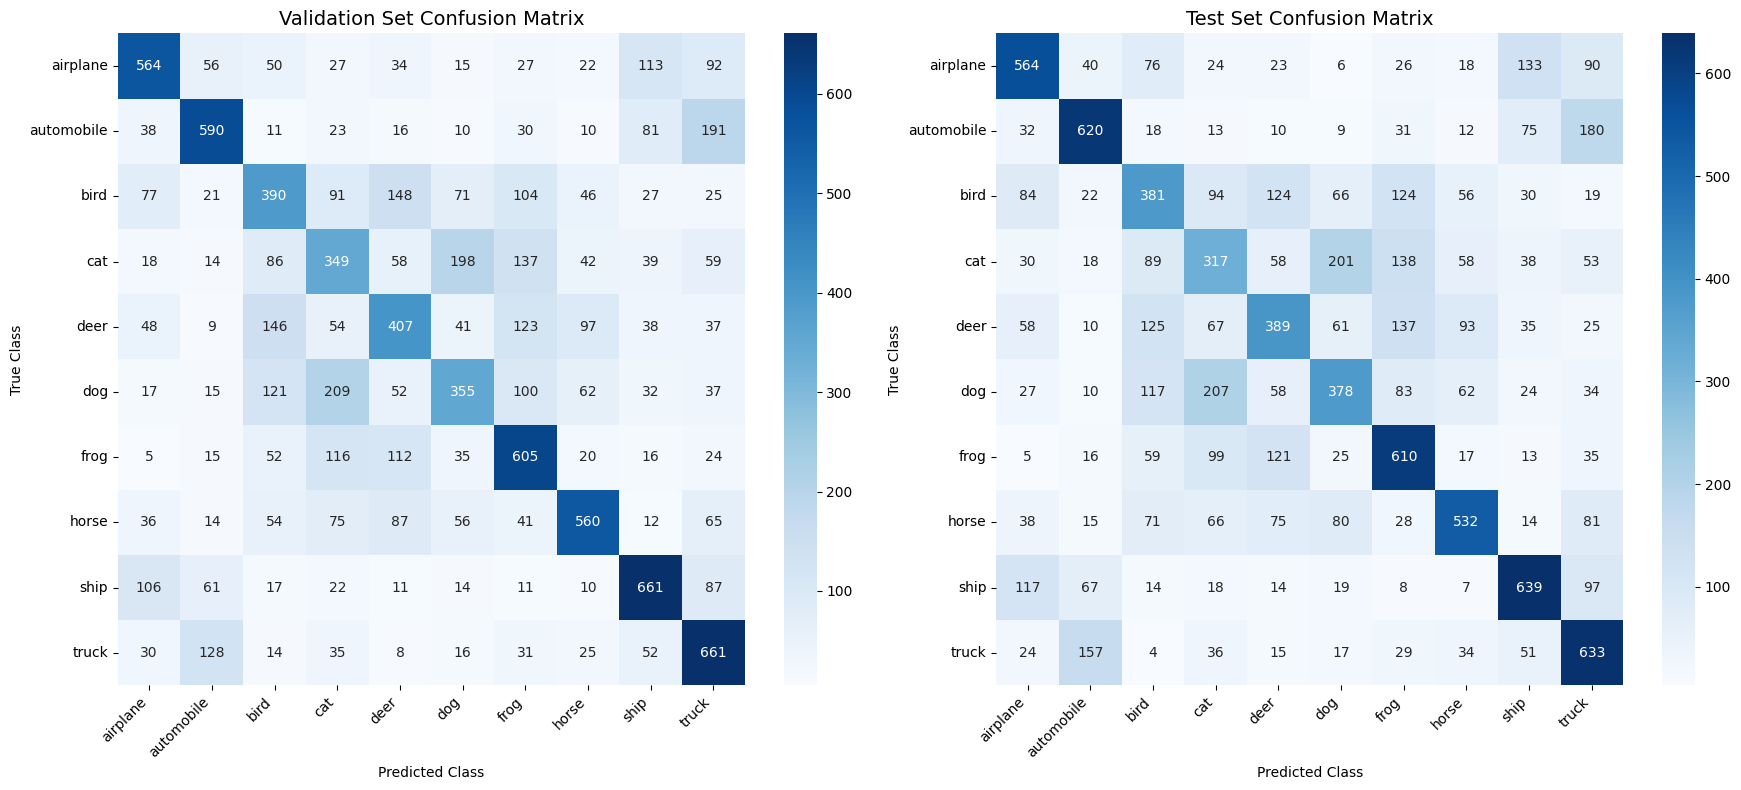

Validation Set - Most Confused Class Pairs:
   1. dog → cat: 209 times
   2. cat → dog: 198 times
   3. automobile → truck: 191 times
   4. bird → deer: 148 times
   5. deer → bird: 146 times
Test Set - Most Confused Class Pairs:
   1. dog → cat: 207 times
   2. cat → dog: 201 times
   3. automobile → truck: 180 times
   4. truck → automobile: 157 times
   5. cat → frog: 138 times
Confusion Pattern Analysis:
Common confusion patterns often reveal:
 Visually similar classes (e.g., truck ↔ automobile)
 Classes with similar backgrounds (e.g., animals in natural settings)
 Scale/viewpoint issues (e.g., distant airplanes vs birds)
 Color/texture similarities
Class Accuracy Comparison (Validation vs Test):
Class        Val Acc    Test Acc   Difference
--------------------------------------------------
airplane     0.564      0.564      0.000     
automobile   0.590      0.620      0.030     
bird         0.390      0.381      0.009     
cat          0.349      0.317      0.032     
deer     

In [17]:
plt.figure(figsize=(18, 8))


plt.subplot(1, 2, 1)
cm_val = confusion_matrix(val_true, val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Validation Set Confusion Matrix', fontsize=14)
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)


plt.subplot(1, 2, 2)
cm_test = confusion_matrix(test_true, test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Test Set Confusion Matrix', fontsize=14)
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


def analyze_confusion_pairs(cm, class_names, dataset_name, top_k=5):

    print(f"{dataset_name} Set - Most Confused Class Pairs:")
    

    cm_off_diag = cm.copy()
    np.fill_diagonal(cm_off_diag, 0)
    

    flat_indices = np.argsort(cm_off_diag.ravel())[-top_k:][::-1]
    
    confused_pairs = []
    for i, flat_idx in enumerate(flat_indices):
        row, col = np.unravel_index(flat_idx, cm_off_diag.shape)
        confusion_count = cm[row, col]
        if confusion_count > 0:
            confused_pairs.append((row, col, confusion_count))
            print(f"   {i+1}. {class_names[row]} → {class_names[col]}: {confusion_count} times")
    
    return confused_pairs

val_confused = analyze_confusion_pairs(cm_val, class_names, "Validation")
test_confused = analyze_confusion_pairs(cm_test, class_names, "Test")


print(f"Confusion Pattern Analysis:")
print("Common confusion patterns often reveal:")
print(" Visually similar classes (e.g., truck ↔ automobile)")
print(" Classes with similar backgrounds (e.g., animals in natural settings)")
print(" Scale/viewpoint issues (e.g., distant airplanes vs birds)")
print(" Color/texture similarities")

val_class_acc = cm_val.diagonal() / cm_val.sum(axis=1)
test_class_acc = cm_test.diagonal() / cm_test.sum(axis=1)

print(f"Class Accuracy Comparison (Validation vs Test):")
print(f"{'Class':<12} {'Val Acc':<10} {'Test Acc':<10} {'Difference':<10}")
print("-" * 50)

for i in range(len(class_names)):
    diff = abs(val_class_acc[i] - test_class_acc[i])
    print(f"{class_names[i]:<12} {val_class_acc[i]:<10.3f} "
          f"{test_class_acc[i]:<10.3f} {diff:<10.3f}")


consistent_classes = []
inconsistent_classes = []

for i in range(len(class_names)):
    diff = abs(val_class_acc[i] - test_class_acc[i])
    if diff < 0.05:  
        consistent_classes.append(class_names[i])
    else:
        inconsistent_classes.append(class_names[i])

print(f"\nConsistency Analysis:")
if consistent_classes:
    print(f"   Consistent performers: {', '.join(consistent_classes)}")
if inconsistent_classes:
    print(f"   Inconsistent performers: {', '.join(inconsistent_classes)}")

## ROC Curve Analysis

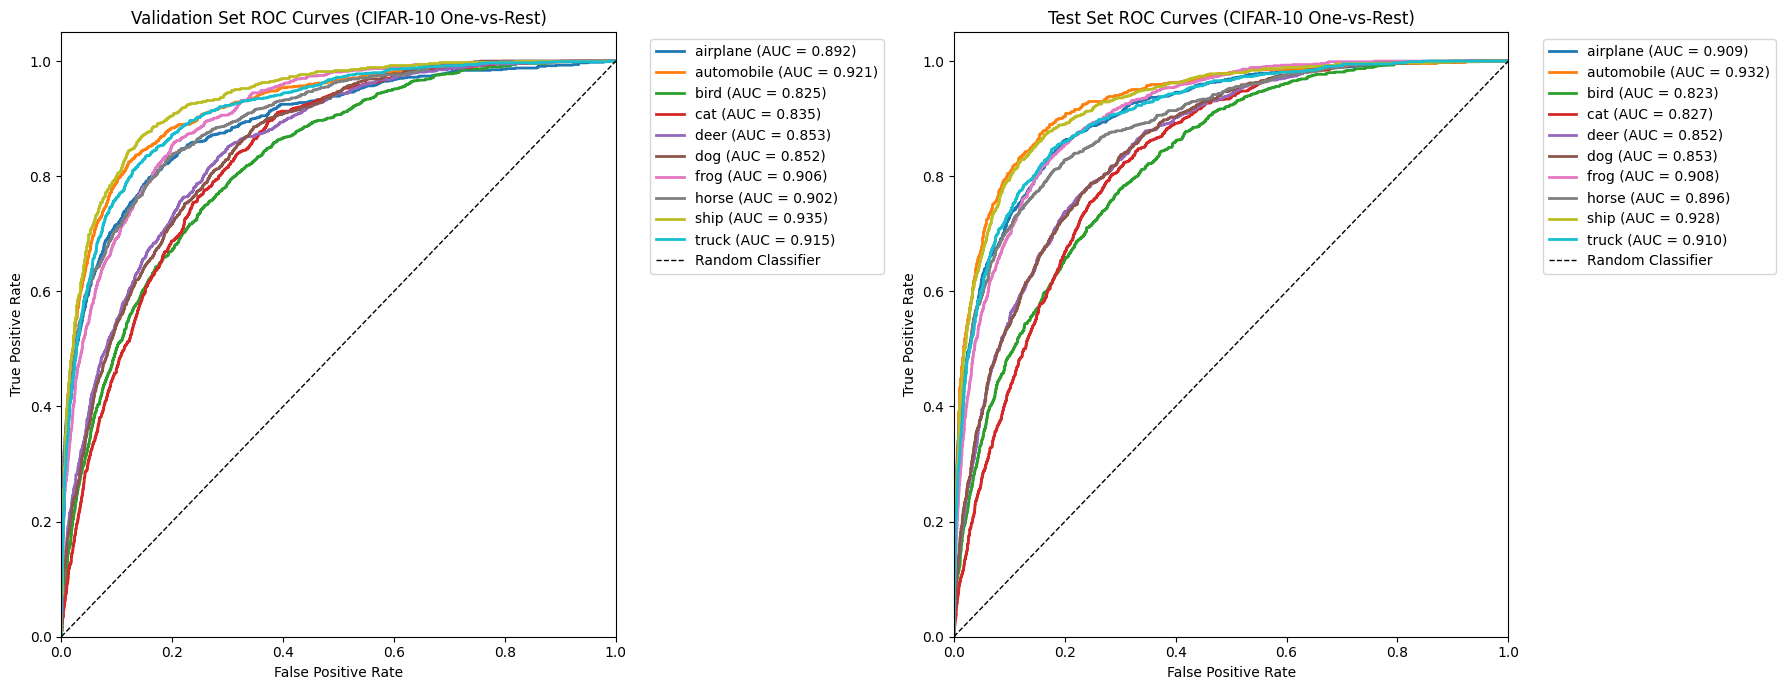

Overall ROC AUC Scores for CIFAR-10 (Macro-Averaged):
    Validation AUC: 0.8836
    Test AUC: 0.8837

Individual Class AUC Scores (Test Set):
   airplane    : 0.909
   automobile  : 0.932
   bird        : 0.823
   cat         : 0.827
   deer        : 0.852
   dog         : 0.853
   frog        : 0.908
   horse       : 0.896
   ship        : 0.928
   truck       : 0.910

Best AUC performance:  automobile (0.932)
Worst AUC performance: bird (0.823)

AUC Performance Distribution:
   Mean AUC: 0.884
   Std AUC: 0.039
   AUC Range: 0.110
   Classes with good AUC (≥0.8): airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck


In [18]:
from sklearn.preprocessing import label_binarize

y_val_binary = label_binarize(y_val, classes=range(10))
y_test_binary = label_binarize(y_test, classes=range(10))

y_val_proba = val_prob  
y_test_proba = test_prob

plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
colors = plt.cm.tab10(np.linspace(0, 1, 10))

for i, color in enumerate(colors):
    fpr, tpr, _ = roc_curve(y_val_binary[:, i], y_val_proba[:, i])
    roc_auc = roc_auc_score(y_val_binary[:, i], y_val_proba[:, i])
    plt.plot(fpr, tpr, color=color, linewidth=2,
             label=f'{class_names[i]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation Set ROC Curves (CIFAR-10 One-vs-Rest)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(1, 2, 2)
for i, color in enumerate(colors):
    fpr, tpr, _ = roc_curve(y_test_binary[:, i], y_test_proba[:, i])
    roc_auc = roc_auc_score(y_test_binary[:, i], y_test_proba[:, i])
    plt.plot(fpr, tpr, color=color, linewidth=2,
             label=f'{class_names[i]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC Curves (CIFAR-10 One-vs-Rest)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

val_auc = roc_auc_score(y_val_binary, y_val_proba, multi_class='ovr', average='macro')
test_auc = roc_auc_score(y_test_binary, y_test_proba, multi_class='ovr', average='macro')

print(f"Overall ROC AUC Scores for CIFAR-10 (Macro-Averaged):")
print(f"    Validation AUC: {val_auc:.4f}")
print(f"    Test AUC: {test_auc:.4f}")

print(f"\nIndividual Class AUC Scores (Test Set):")
class_aucs = []
for i in range(10):
    auc = roc_auc_score(y_test_binary[:, i], y_test_proba[:, i])
    class_aucs.append(auc)
    print(f"   {class_names[i]:12s}: {auc:.3f}")

best_auc_idx = np.argmax(class_aucs)
worst_auc_idx = np.argmin(class_aucs)

print(f"\nBest AUC performance:  {class_names[best_auc_idx]} ({class_aucs[best_auc_idx]:.3f})")
print(f"Worst AUC performance: {class_names[worst_auc_idx]} ({class_aucs[worst_auc_idx]:.3f})")

print(f"\nAUC Performance Distribution:")
print(f"   Mean AUC: {np.mean(class_aucs):.3f}")
print(f"   Std AUC: {np.std(class_aucs):.3f}")
print(f"   AUC Range: {np.max(class_aucs) - np.min(class_aucs):.3f}")

good_auc_classes = [class_names[i] for i, auc in enumerate(class_aucs) if auc >= 0.8]
poor_auc_classes = [class_names[i] for i, auc in enumerate(class_aucs) if auc < 0.7]

if good_auc_classes:
    print(f"   Classes with good AUC (≥0.8): {', '.join(good_auc_classes)}")
if poor_auc_classes:
    print(f"   Classes with poor AUC (<0.7): {', '.join(poor_auc_classes)}")

## Weight Visualization and Analysis

### Understanding Learned Features:
For an MLP, the first layer tends to learn low-level detectors (colors, edges, simple textures). Deeper layers compose these into higher-level patterns, and the final layer combines hidden features to score each class.

### What we visualize here:
- First-layer neuron weight maps (reshaped to 32×32×3) for representative neurons
- Final layer (class) weight/bias magnitude summaries

### Weight Interpretation:
- **Positive weights**: Features that increase the score
- **Negative weights**: Features that decrease the score
- **Large magnitude**: More important features
- **Small magnitude**: Less important features

Learned Parameters Analysis (MLP):
   fc1 weight: (1024, 3072), bias: (1024,)
   fc2 weight: (512, 1024), bias: (512,)
   fc3 weight: (10, 512), bias: (10,)
   fc1 weight range: [-0.1760, 0.2098], std: 0.0298
   fc3 weight range: [-0.1536, 0.1238], std: 0.0528


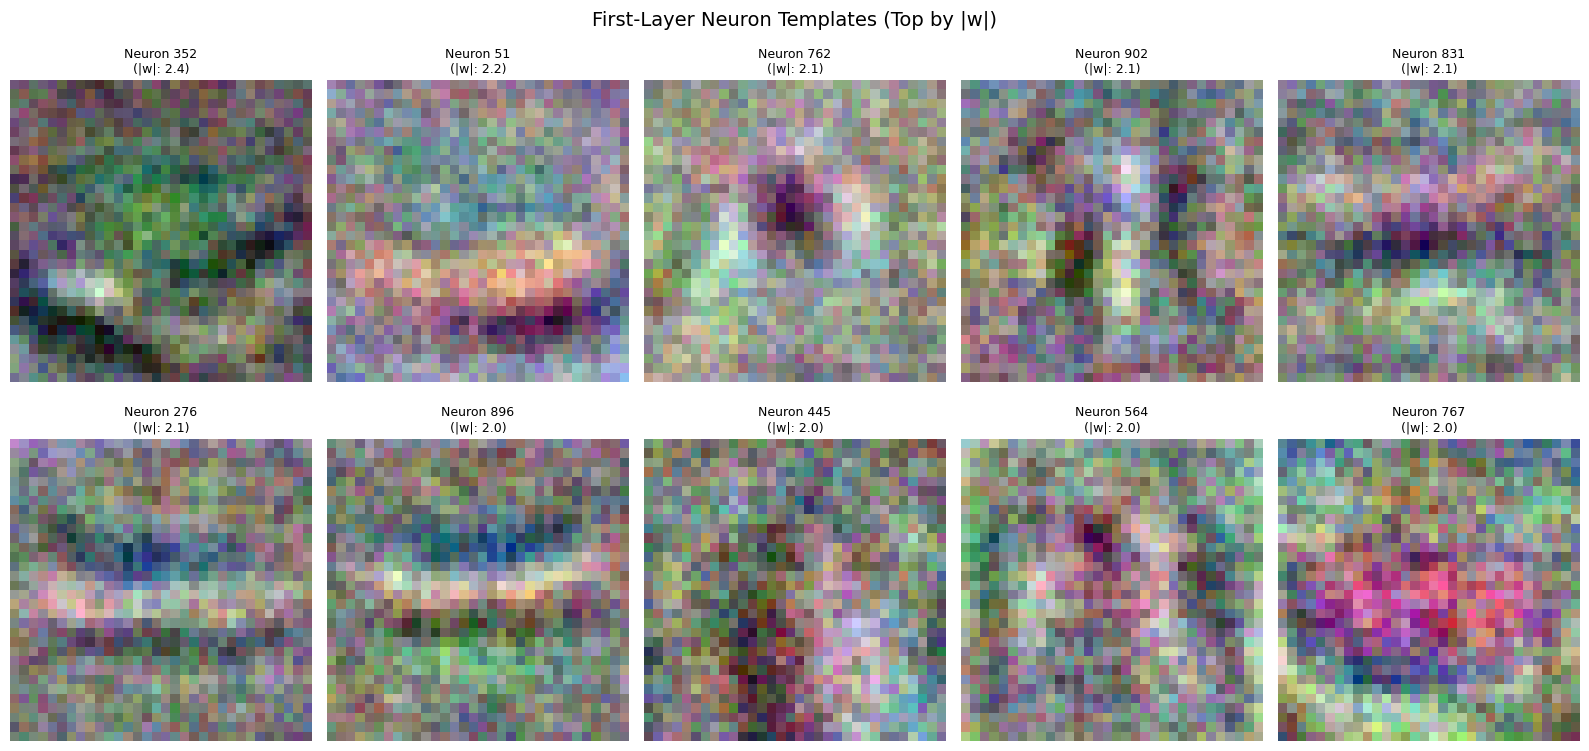


Final Layer (Class) Weight Statistics:
Class        |W| mean   W std      Bias      
--------------------------------------------------
airplane     0.0437     0.0517     -0.007    
automobile   0.0479     0.0559     -0.335    
bird         0.0442     0.0526     0.083     
cat          0.0435     0.0517     0.001     
deer         0.0436     0.0516     0.335     
dog          0.0437     0.0515     -0.102    
frog         0.0441     0.0526     0.261     
horse        0.0441     0.0521     -0.121    
ship         0.0480     0.0560     0.017     
truck        0.0442     0.0519     -0.180    


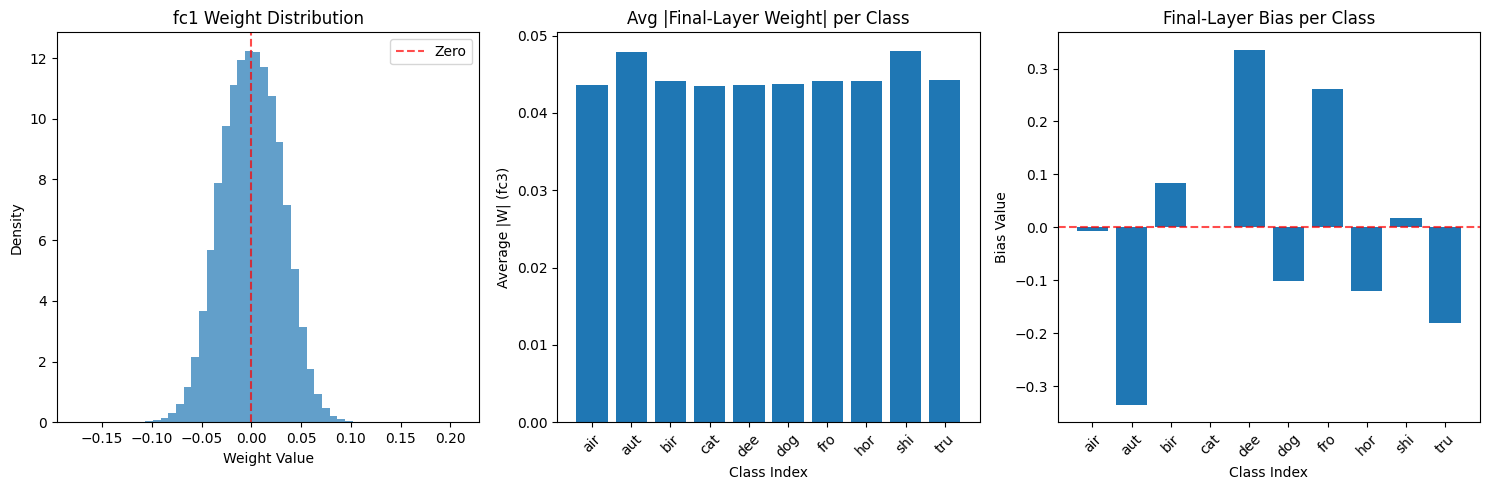


Interpretation Notes:
  • First-layer templates highlight color/edge detectors.
  • Final layer weights indicate which hidden features support each class.
  • Larger |W| and |bias| magnitudes reflect stronger influence.


In [ ]:
def normalize_for_visualization(w):
    w_min, w_max = w.min(), w.max()
    if w_max - w_min == 0:
        return np.zeros_like(w)
    return (w - w_min) / (w_max - w_min)

if hasattr(model, 'linear'):

    weights = model.linear.weight.detach().cpu().numpy()
    bias = model.linear.bias.detach().cpu().numpy()

    print("Learned Parameters Analysis (Single-Layer):")
    print(f"   Weight matrix shape: {weights.shape}")
    print(f"   Bias vector shape: {bias.shape}")
    print(f"   Weight range: [{weights.min():.4f}, {weights.max():.4f}]")
    print(f"   Weight std: {weights.std():.4f}")
    print(f"   Bias range: [{bias.min():.4f}, {bias.max():.4f}]")

    weights_reshaped = weights.reshape(10, 32, 32, 3)

    plt.figure(figsize=(16, 8))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        weight_img = normalize_for_visualization(weights_reshaped[i])
        plt.imshow(weight_img)
        plt.title(f'{class_names[i]}\n(bias: {bias[i]:.3f})', fontsize=10)
        plt.axis('off')
    plt.suptitle('Learned Weight Templates (Linear model)', fontsize=14)
    plt.tight_layout()
    plt.show()

    print("\nPer-Class Weight Statistics:")
    print(f"{'Class':<12} {'Weight Mean':<12} {'Weight Std':<12} {'Bias':<8} {'Max Weight':<12}")
    print("-" * 65)
    for i in range(10):
        class_weights = weights[i]
        print(f"{class_names[i]:<12} {class_weights.mean():<12.4f} "
              f"{class_weights.std():<12.4f} {bias[i]:<8.3f} "
              f"{class_weights.max():<12.4f}")

    weight_magnitudes = np.abs(weights).mean(axis=1)
    print(f"\nWeight Magnitude Analysis:")
    print(f"   Average weight magnitude per class:")
    for i in range(10):
        print(f"      {class_names[i]:<12}: {weight_magnitudes[i]:.4f}")

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.hist(weights.flatten(), bins=50, alpha=0.7, density=True)
    plt.title('Weight Distribution (All Classes)')
    plt.xlabel('Weight Value')
    plt.ylabel('Density')
    plt.axvline(0, color='red', linestyle='--', alpha=0.7, label='Zero')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.bar(range(10), weight_magnitudes)
    plt.title('Average Weight Magnitude per Class')
    plt.xlabel('Class Index')
    plt.ylabel('Average |Weight|')
    plt.xticks(range(10), [name[:3] for name in class_names], rotation=45)

    plt.subplot(1, 3, 3)
    plt.bar(range(10), bias)
    plt.title('Bias per Class')
    plt.xlabel('Class Index')
    plt.ylabel('Bias Value')
    plt.xticks(range(10), [name[:3] for name in class_names], rotation=45)
    plt.axhline(0, color='red', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    print("\nWeight Template Interpretation:")
    print("     Bright regions: Features that increase class probability")
    print("     Dark regions: Features that decrease class probability")
    print("     Templates show what linear classifier 'expects' to see")
    print("     Single template per class = major limitation of linear models")

else:
    w1 = model.fc1.weight.detach().cpu().numpy()  
    b1 = model.fc1.bias.detach().cpu().numpy()
    w2 = model.fc2.weight.detach().cpu().numpy()  
    b2 = model.fc2.bias.detach().cpu().numpy()
    w3 = model.fc3.weight.detach().cpu().numpy()  
    b3 = model.fc3.bias.detach().cpu().numpy()

    print("Learned Parameters Analysis (MLP):")
    print(f"   fc1 weight: {w1.shape}, bias: {b1.shape}")
    print(f"   fc2 weight: {w2.shape}, bias: {b2.shape}")
    print(f"   fc3 weight: {w3.shape}, bias: {b3.shape}")
    print(f"   fc1 weight range: [{w1.min():.4f}, {w1.max():.4f}], std: {w1.std():.4f}")
    print(f"   fc3 weight range: [{w3.min():.4f}, {w3.max():.4f}], std: {w3.std():.4f}")


    H1 = w1.shape[0]
    w1_imgs = w1.reshape(H1, 32, 32, 3)
    importance = np.linalg.norm(w1, axis=1)
    top_k = 10
    top_idx = np.argsort(importance)[-top_k:][::-1]

    plt.figure(figsize=(16, 8))
    for i, idx in enumerate(top_idx):
        plt.subplot(2, 5, i+1)
        img = normalize_for_visualization(w1_imgs[idx])
        plt.imshow(img)
        plt.title(f'Neuron {idx}\n(|w|: {importance[idx]:.1f})', fontsize=9)
        plt.axis('off')
    plt.suptitle('First-Layer Neuron Templates (Top by |w|)', fontsize=14)
    plt.tight_layout()
    plt.show()


    print("\nFinal Layer (Class) Weight Statistics:")
    print(f"{'Class':<12} {'|W| mean':<10} {'W std':<10} {'Bias':<10}")
    print("-" * 50)
    w3_abs_mean = np.abs(w3).mean(axis=1)
    for i in range(10):
        print(f"{class_names[i]:<12} {w3_abs_mean[i]:<10.4f} {w3[i].std():<10.4f} {b3[i]:<10.3f}")


    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.hist(w1.flatten(), bins=50, alpha=0.7, density=True)
    plt.title('fc1 Weight Distribution')
    plt.xlabel('Weight Value')
    plt.ylabel('Density')
    plt.axvline(0, color='red', linestyle='--', alpha=0.7, label='Zero')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.bar(range(10), w3_abs_mean)
    plt.title('Avg |Final-Layer Weight| per Class')
    plt.xlabel('Class Index')
    plt.ylabel('Average |W| (fc3)')
    plt.xticks(range(10), [name[:3] for name in class_names], rotation=45)

    plt.subplot(1, 3, 3)
    plt.bar(range(10), b3)
    plt.title('Final-Layer Bias per Class')
    plt.xlabel('Class Index')
    plt.ylabel('Bias Value')
    plt.xticks(range(10), [name[:3] for name in class_names], rotation=45)
    plt.axhline(0, color='red', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    print("\nInterpretation Notes:")
    print("  • First-layer templates highlight color/edge detectors.")
    print("  • Final layer weights indicate which hidden features support each class.")
    print("  • Larger |W| and |bias| magnitudes reflect stronger influence.")

## Error Analysis and Misclassifications

Misclassification Analysis:
   Total test samples: 10000
   Correctly classified: 5063 (50.6%)
   Misclassified: 4937 (49.4%)

Prediction Confidence Analysis:
   Correct predictions - Mean confidence: 0.594 ± 0.242
   Incorrect predictions - Mean confidence: 0.401 ± 0.179
   High confidence errors (>80%): 190


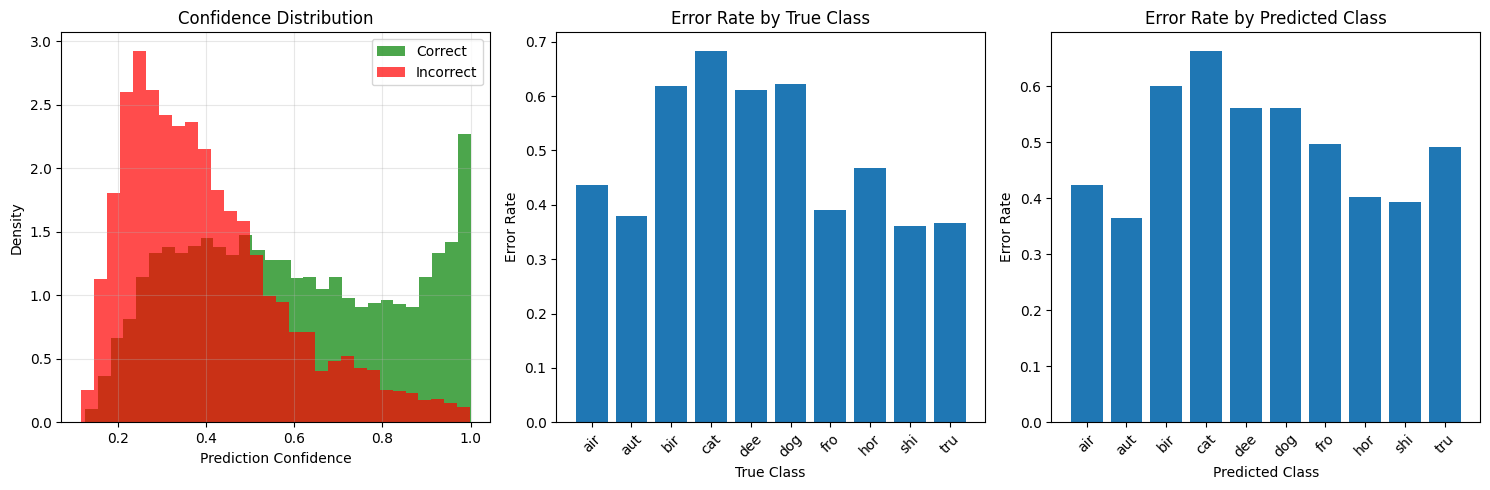


Showing 12 random misclassification examples:


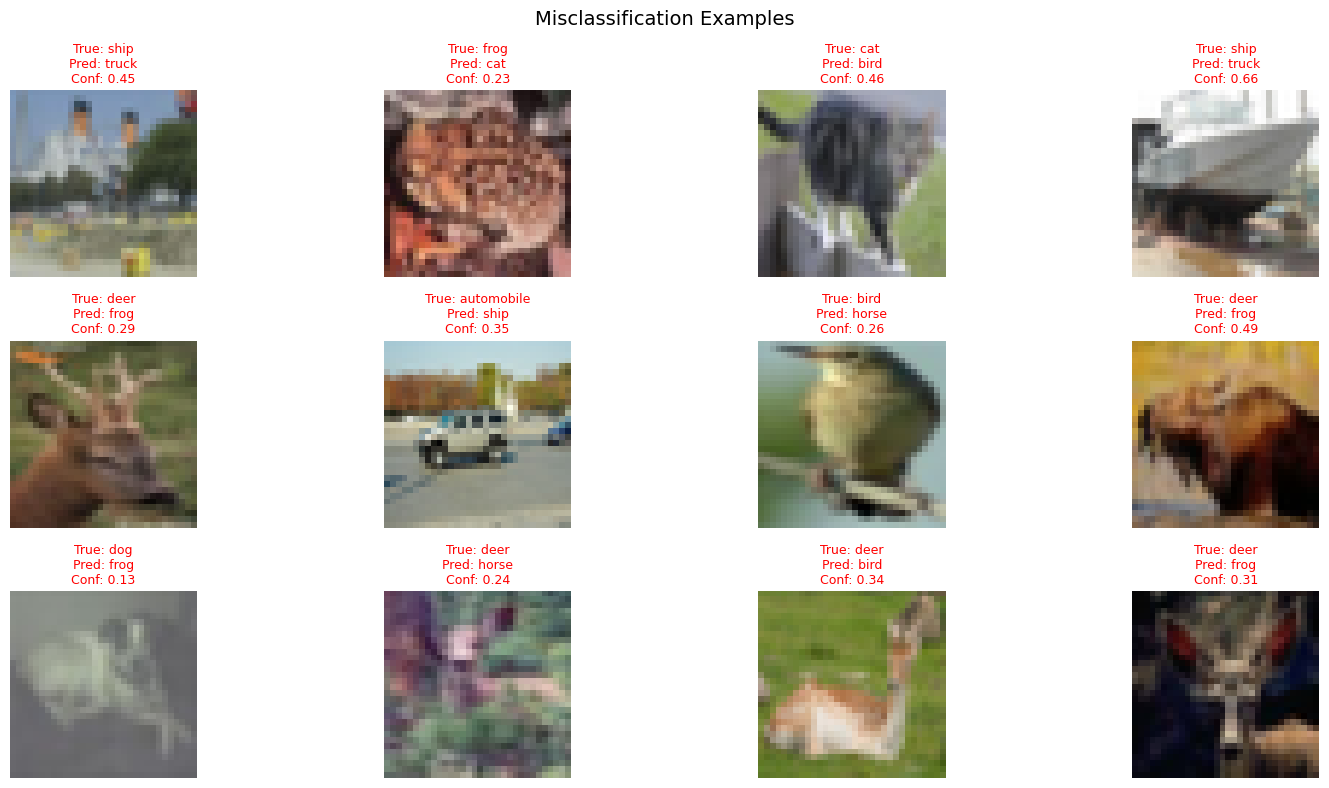


Showing high confidence errors (model was very confident but wrong):


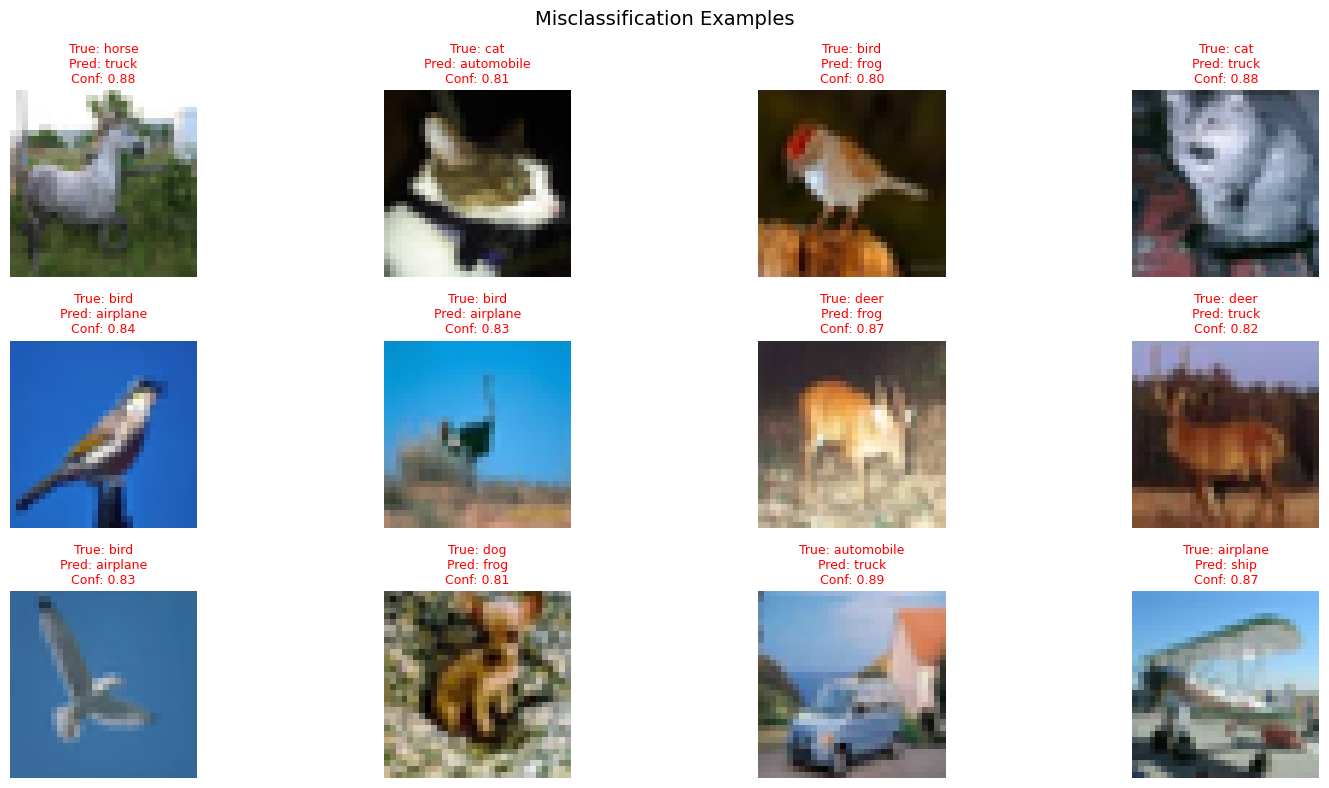

In [20]:
misclassified_indices = np.where(test_pred != test_true)[0]
correctly_classified_indices = np.where(test_pred == test_true)[0]

print(f"Misclassification Analysis:")
print(f"   Total test samples: {len(test_true)}")
print(f"   Correctly classified: {len(correctly_classified_indices)} ({len(correctly_classified_indices)/len(test_true)*100:.1f}%)")
print(f"   Misclassified: {len(misclassified_indices)} ({len(misclassified_indices)/len(test_true)*100:.1f}%)")


def analyze_prediction_confidence(probabilities, predictions, true_labels):    
    max_probs = np.max(probabilities, axis=1)
    correct_mask = (predictions == true_labels)
    
    correct_confidence = max_probs[correct_mask]
    incorrect_confidence = max_probs[~correct_mask]
    
    print(f"\nPrediction Confidence Analysis:")
    print(f"   Correct predictions - Mean confidence: {correct_confidence.mean():.3f} ± {correct_confidence.std():.3f}")
    print(f"   Incorrect predictions - Mean confidence: {incorrect_confidence.mean():.3f} ± {incorrect_confidence.std():.3f}")
    
    high_conf_errors = np.where((~correct_mask) & (max_probs > 0.8))[0]
    print(f"   High confidence errors (>80%): {len(high_conf_errors)}")
    
    return high_conf_errors

high_conf_errors = analyze_prediction_confidence(test_prob, test_pred, test_true)


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
correct_conf = np.max(test_prob[test_pred == test_true], axis=1)
incorrect_conf = np.max(test_prob[test_pred != test_true], axis=1)

plt.hist(correct_conf, bins=30, alpha=0.7, label='Correct', density=True, color='green')
plt.hist(incorrect_conf, bins=30, alpha=0.7, label='Incorrect', density=True, color='red')
plt.xlabel('Prediction Confidence')
plt.ylabel('Density')
plt.title('Confidence Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)

true_class_errors = []
for i in range(10):
    class_mask = (test_true == i)
    class_errors = (test_pred[class_mask] != test_true[class_mask]).sum()
    error_rate = class_errors / class_mask.sum() if class_mask.sum() > 0 else 0
    true_class_errors.append(error_rate)

plt.bar(range(10), true_class_errors)
plt.title('Error Rate by True Class')
plt.xlabel('True Class')
plt.ylabel('Error Rate')
plt.xticks(range(10), [name[:3] for name in class_names], rotation=45)

plt.subplot(1, 3, 3)

pred_class_errors = []
for i in range(10):
    pred_mask = (test_pred == i)
    if pred_mask.sum() > 0:
        class_errors = (test_pred[pred_mask] != test_true[pred_mask]).sum()
        error_rate = class_errors / pred_mask.sum()
    else:
        error_rate = 0
    pred_class_errors.append(error_rate)

plt.bar(range(10), pred_class_errors)
plt.title('Error Rate by Predicted Class')
plt.xlabel('Predicted Class')
plt.ylabel('Error Rate')
plt.xticks(range(10), [name[:3] for name in class_names], rotation=45)

plt.tight_layout()
plt.show()


def show_misclassification_examples(X_test_orig, true_labels, pred_labels, probabilities, 
                                  indices, class_names, n_examples=12):
    
    plt.figure(figsize=(16, 8))
    
    X_test_images = X_test_orig.reshape(-1, 32, 32, 3)
    
    for i in range(min(n_examples, len(indices))):
        idx = indices[i]
        
        plt.subplot(3, 4, i+1)
        plt.imshow(X_test_images[idx])
        
        true_class = class_names[true_labels[idx]]
        pred_class = class_names[pred_labels[idx]]
        confidence = probabilities[idx].max()
        
        plt.title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}', 
                 fontsize=9, color='red')
        plt.axis('off')
    
    plt.suptitle('Misclassification Examples', fontsize=14)
    plt.tight_layout()
    plt.show()


random_misclassified = np.random.choice(misclassified_indices, 
                                      min(12, len(misclassified_indices)), 
                                      replace=False)

print(f"\nShowing {len(random_misclassified)} random misclassification examples:")
show_misclassification_examples(X_test, test_true, test_pred, test_prob, 
                               random_misclassified, class_names)


if len(high_conf_errors) > 0:
    print(f"\nShowing high confidence errors (model was very confident but wrong):")
    show_misclassification_examples(X_test, test_true, test_pred, test_prob, 
                                   high_conf_errors[:12], class_names)